In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import category_encoders as ce
from sklearn.model_selection import train_test_split

### EDA

In [3]:
df = pd.read_excel("../data/raw/train_file.xlsx")

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,0,nonexistent,no


In [5]:
df.shape

(32910, 15)

In [6]:
df.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
previous        int64
poutcome       object
y              object
dtype: object

In [7]:
df.isna().sum().sum()

0

#### traget encoding

In [8]:
df["y"] = df["y"].map({"no": 0, "yes": 1})

In [9]:
df["y"].value_counts()

y
0    29203
1     3707
Name: count, dtype: int64

In [10]:
df["y"].mean()  # --> disbalanced

0.11264053479185658

#### features

In [12]:
cat_feats = df.drop("y", axis=1).select_dtypes(include="object").columns.tolist()

In [13]:
int_feats = df.drop("y", axis=1).select_dtypes(exclude="object").columns.tolist()

In [14]:
cat_feats = cat_feats + ["campaign", "previous"]
int_feats = [x for x in int_feats if x not in ["campaign", "previous"]]

In [15]:
cat_feats, int_feats

(['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome',
  'campaign',
  'previous'],
 ['age', 'duration'])

#### int_feats

In [16]:
df.groupby("y")[int_feats].agg(["count", "median", "mean", "std"]).reset_index()

y    age                              duration                     \
      count median       mean        std    count median        mean   
0  0  29203   38.0  39.907133   9.891615    29203  164.0  221.161833   
1  1   3707   37.0  40.856757  13.755703     3707  449.0  549.662530   

               
          std  
0  208.353892  
1  397.678053

In [17]:
bins = 20

for col in int_feats:
    df[f"{col}_bins"] = pd.qcut(df[col], q=bins).astype(str)

    display(df[f"{col}_bins"].value_counts().sort_index())

age_bins
(16.999, 26.0]    1928
(26.0, 28.0]      1471
(28.0, 30.0]      2528
(30.0, 31.0]      1550
(31.0, 32.0]      1473
(32.0, 33.0]      1442
(33.0, 34.0]      1403
(34.0, 35.0]      1415
(35.0, 37.0]      2560
(37.0, 38.0]      1139
(38.0, 40.0]      2073
(40.0, 41.0]      1031
(41.0, 43.0]      1741
(43.0, 45.0]      1694
(45.0, 47.0]      1569
(47.0, 49.0]      1445
(49.0, 52.0]      1927
(52.0, 55.0]      1662
(55.0, 58.0]      1538
(58.0, 98.0]      1321
Name: count, dtype: int64

duration_bins
(-0.001, 36.0]     1663
(103.0, 117.0]     1650
(117.0, 131.0]     1637
(131.0, 146.0]     1598
(146.0, 162.0]     1641
(162.0, 180.0]     1676
(180.0, 200.0]     1664
(200.0, 221.0]     1583
(221.0, 248.0]     1663
(248.0, 280.0]     1645
(280.0, 319.0]     1616
(319.0, 369.0]     1662
(36.0, 59.0]       1670
(369.0, 438.0]     1630
(438.0, 550.0]     1646
(550.0, 750.0]     1644
(59.0, 75.0]       1668
(75.0, 89.0]       1648
(750.0, 4918.0]    1643
(89.0, 103.0]      1663
Name: count, dtype: int64

In [18]:
int_feats_bins = [x for x in df if "bins" in x]

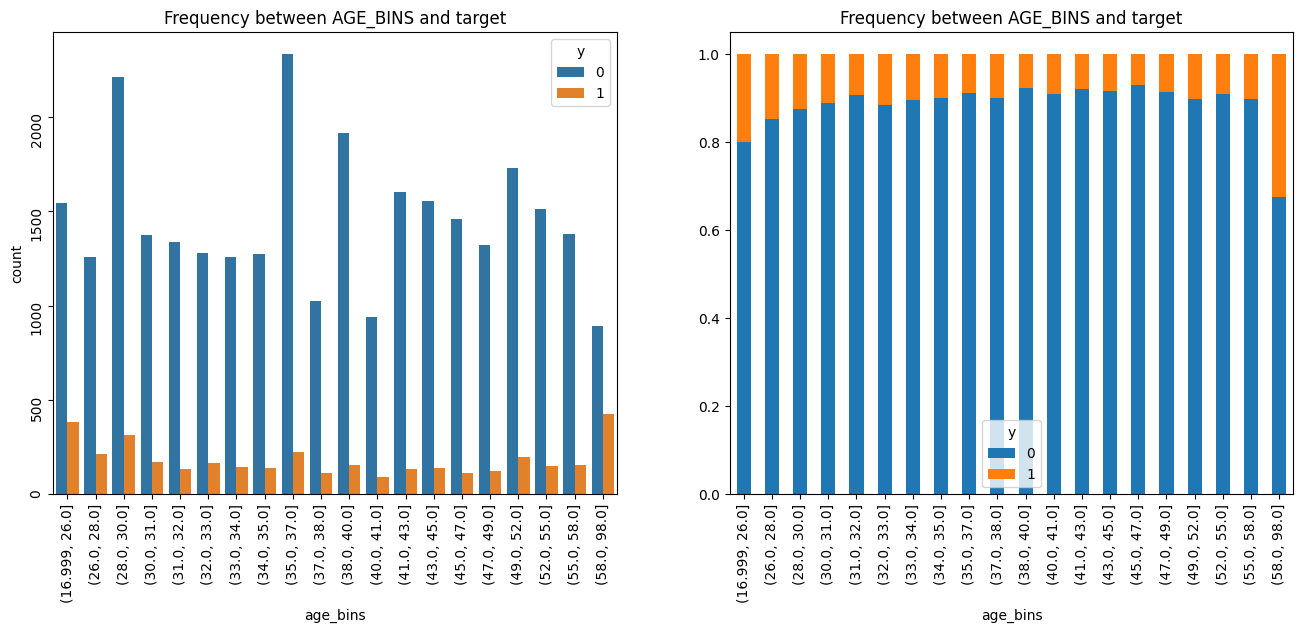

----------------------------------------------------------------------------------------------------


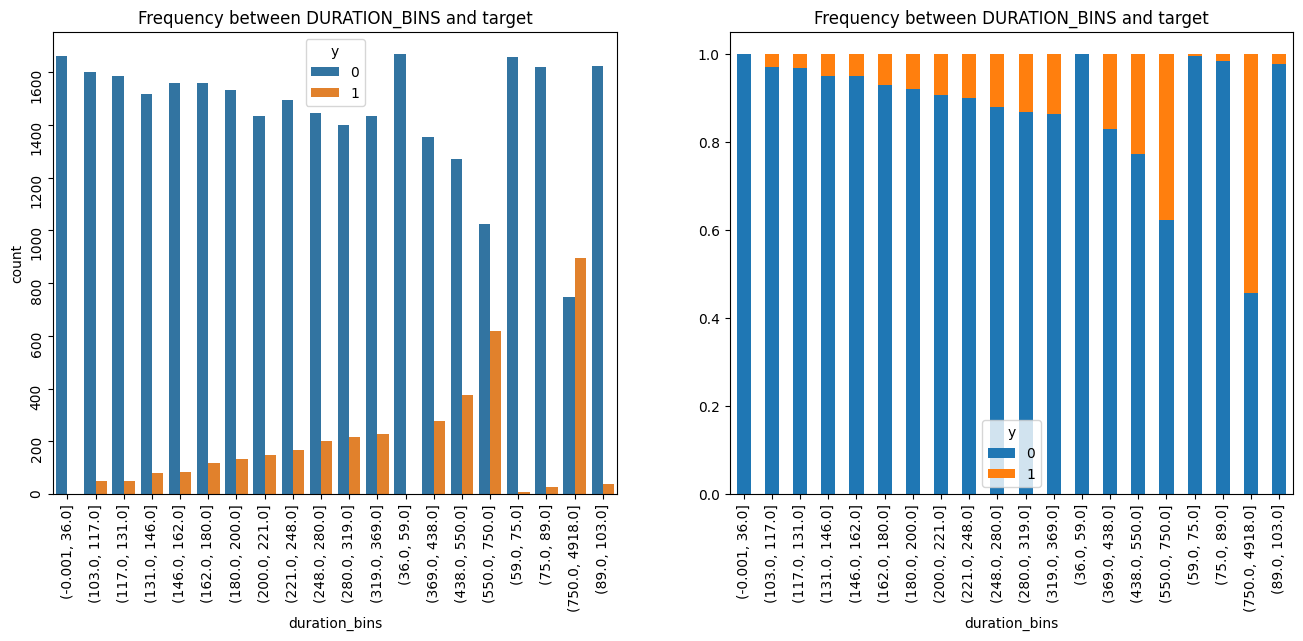

----------------------------------------------------------------------------------------------------


In [19]:
for cf in int_feats_bins:
    # display(df.groupby('job')['y'].agg(['count', 'median', 'mean', 'std']))
    df_freq = df.groupby([cf, "y"])[cf].count().reset_index(name="count")
    df_stack = df.groupby(cf)["y"].value_counts(normalize=True).unstack().fillna(0)

    figure, axis = plt.subplots(1, 2, figsize=(16, 6))

    sns.barplot(data=df_freq, x=cf, hue="y", y="count", ax=axis[0])
    axis[0].tick_params(rotation=90)
    axis[0].set_title(f"Frequency between {cf.upper()} and target")

    df_stack.plot(
        kind="bar", stacked=True, color=["tab:blue", "tab:orange"], ax=axis[1]
    )
    axis[1].set_title(f"Frequency between {cf.upper()} and target")
    plt.show()

    print("-" * 100)

In [31]:
df.groupby(pd.qcut(df["age"], q=5), observed=False).agg(
    {"y": ["count", "median", "mean", "std"]}
)

y                           
               count median      mean       std
age                                            
(16.999, 31.0]  7477    0.0  0.145112  0.352237
(31.0, 35.0]    5733    0.0  0.102564  0.303415
(35.0, 41.0]    6803    0.0  0.087020  0.281886
(41.0, 49.0]    6449    0.0  0.079547  0.270612
(49.0, 98.0]    6448    0.0  0.144076  0.351194

In [32]:
df.groupby(pd.qcut(df["duration"], q=5), observed=False).agg(
    {"y": ["count", "median", "mean", "std"]}
)

y                           
                count median      mean       std
duration                                        
(-0.001, 89.0]   6649    0.0  0.005264  0.072367
(89.0, 146.0]    6548    0.0  0.033445  0.179810
(146.0, 221.0]   6564    0.0  0.073126  0.260363
(221.0, 369.0]   6586    0.0  0.122684  0.328100
(369.0, 4918.0]  6563    0.0  0.329880  0.470205

#### cat_feats

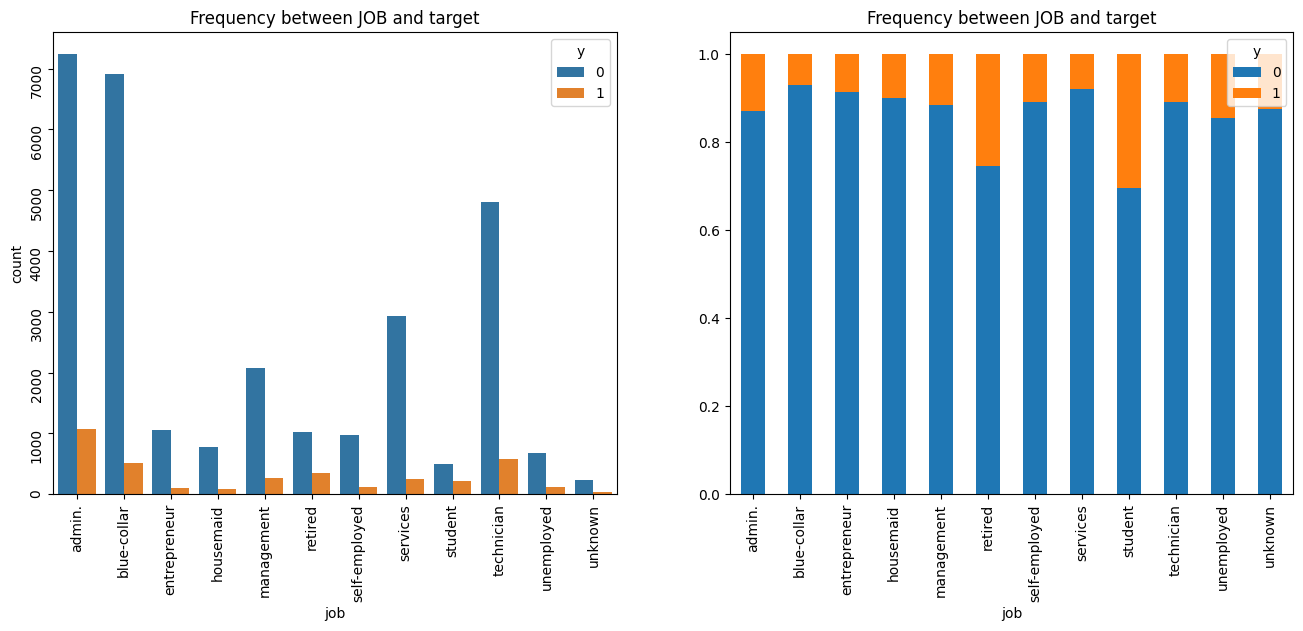

----------------------------------------------------------------------------------------------------


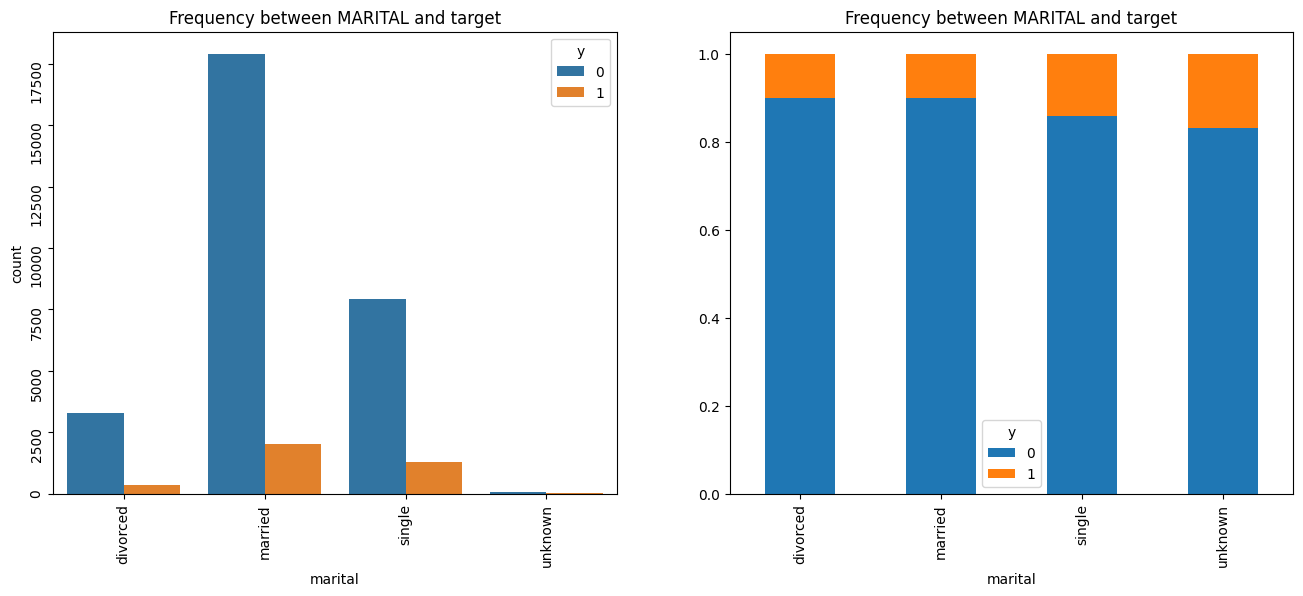

----------------------------------------------------------------------------------------------------


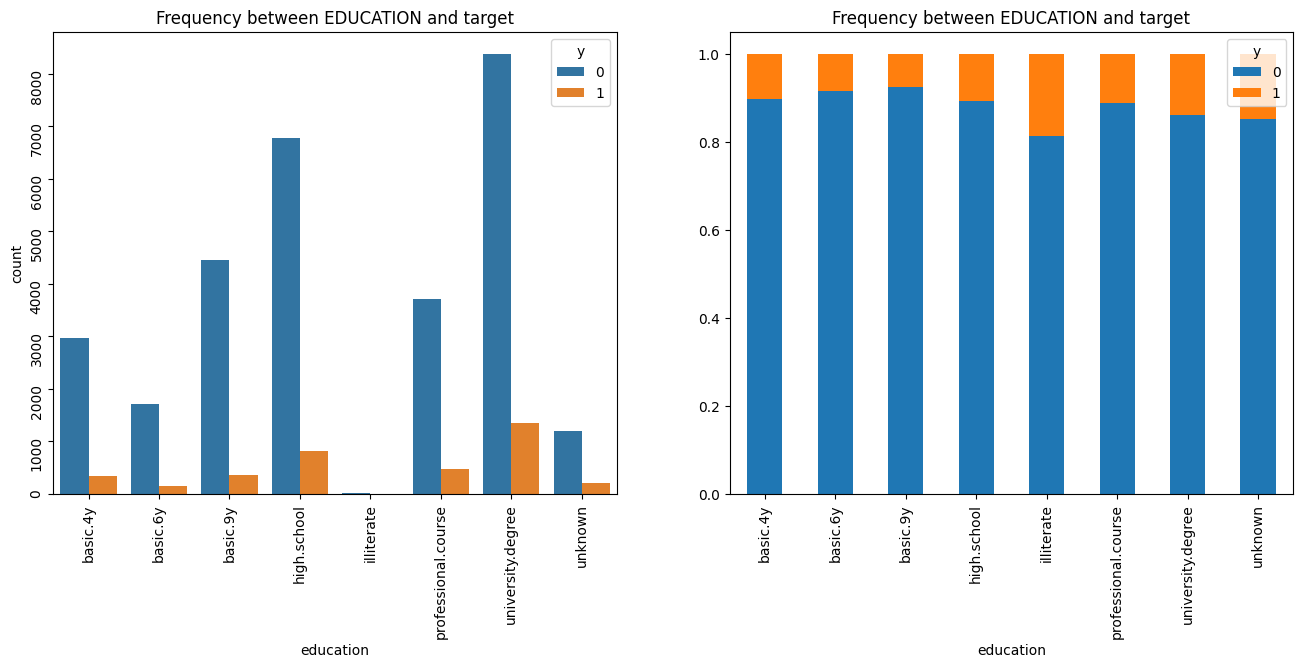

----------------------------------------------------------------------------------------------------


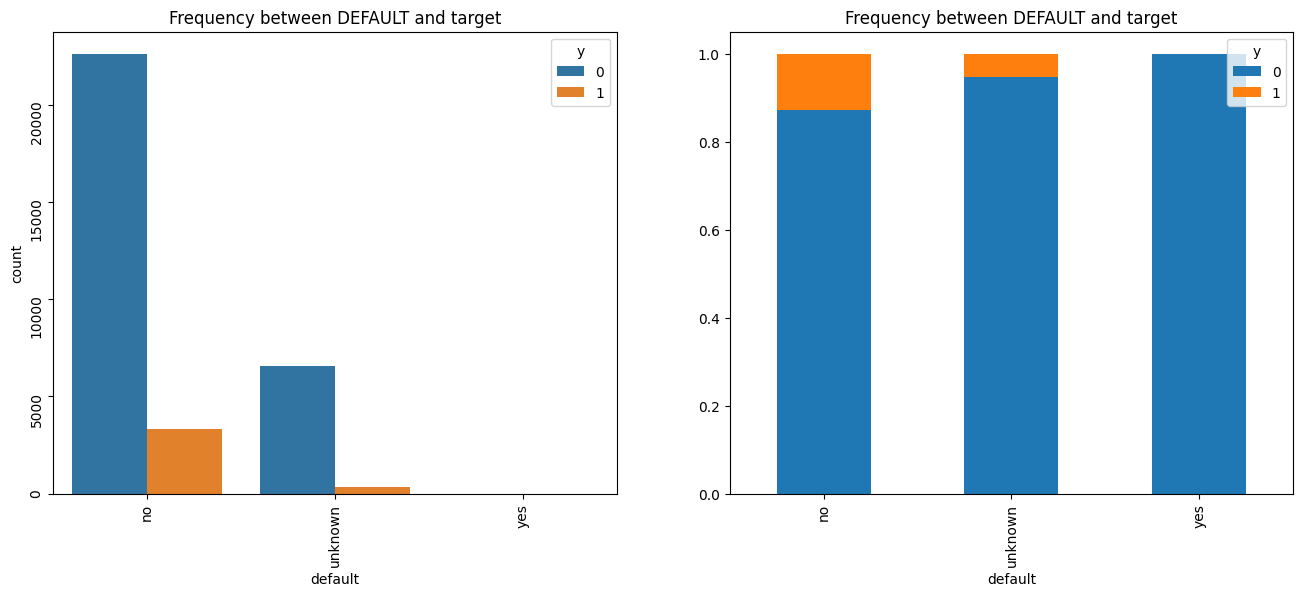

----------------------------------------------------------------------------------------------------


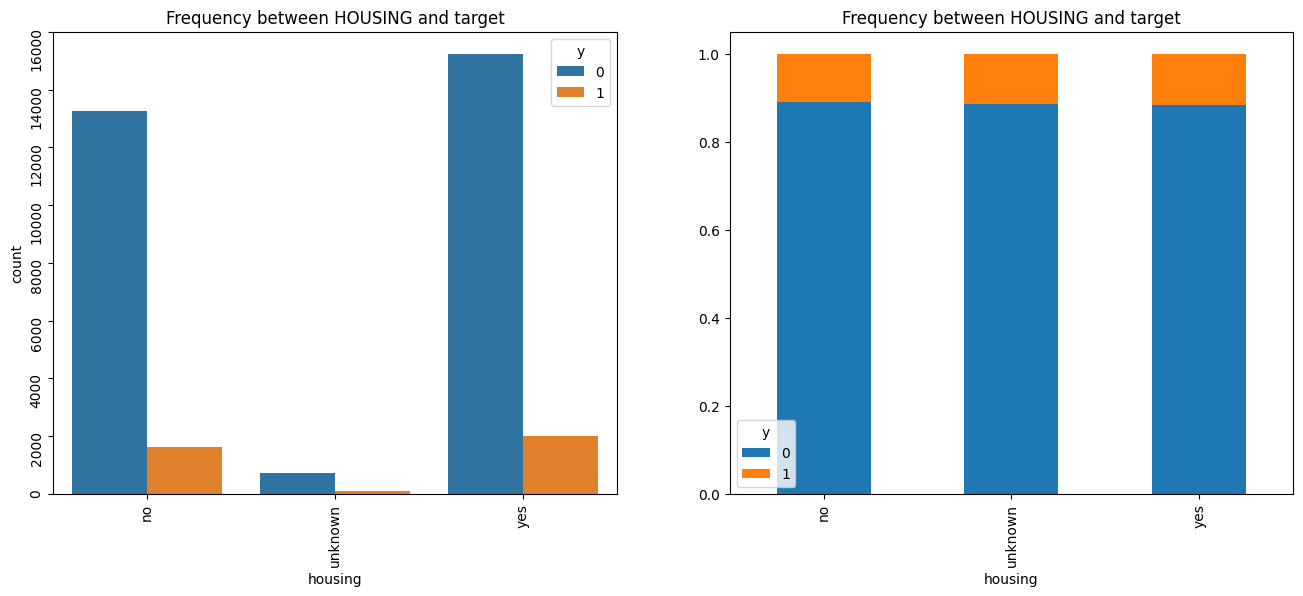

----------------------------------------------------------------------------------------------------


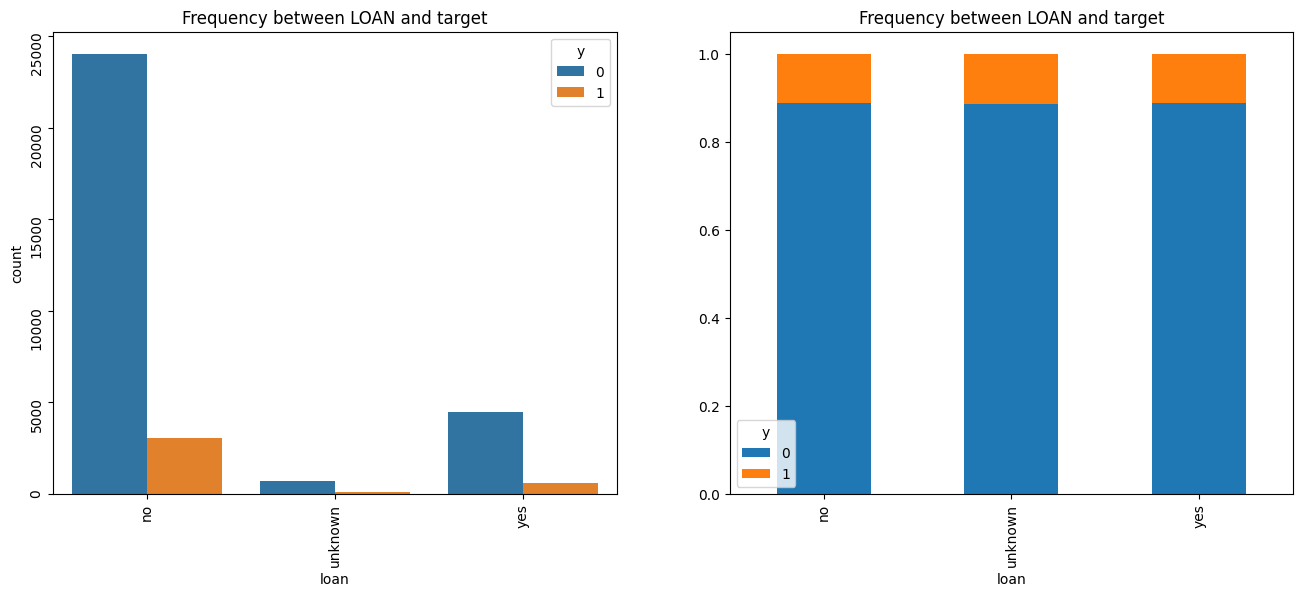

----------------------------------------------------------------------------------------------------


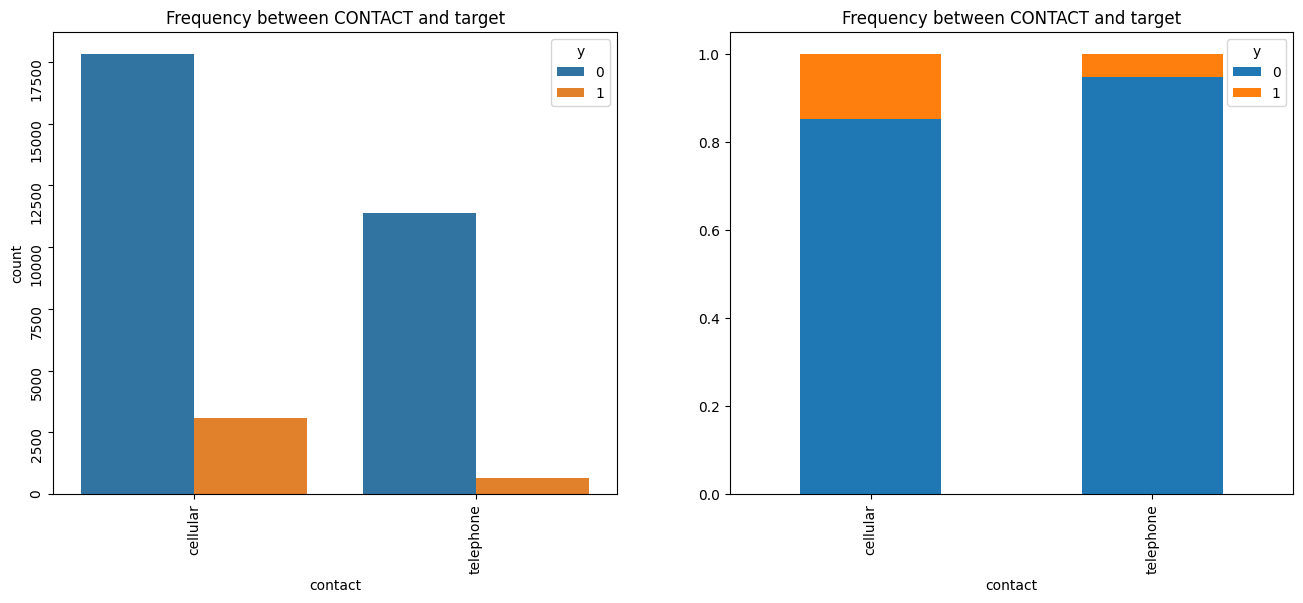

----------------------------------------------------------------------------------------------------


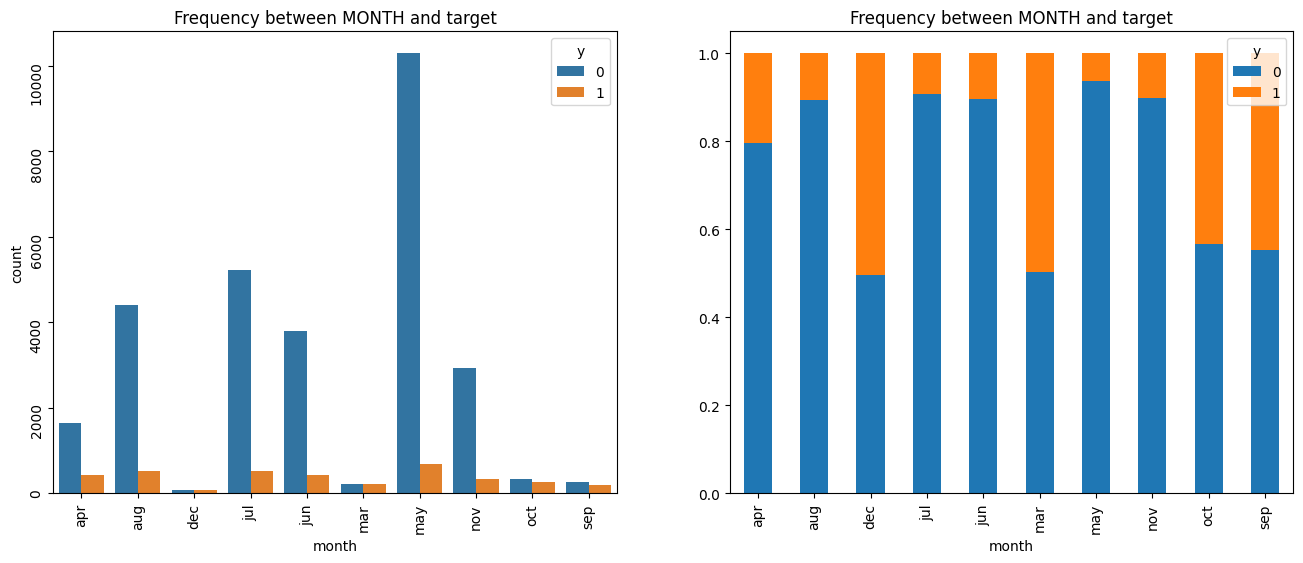

----------------------------------------------------------------------------------------------------


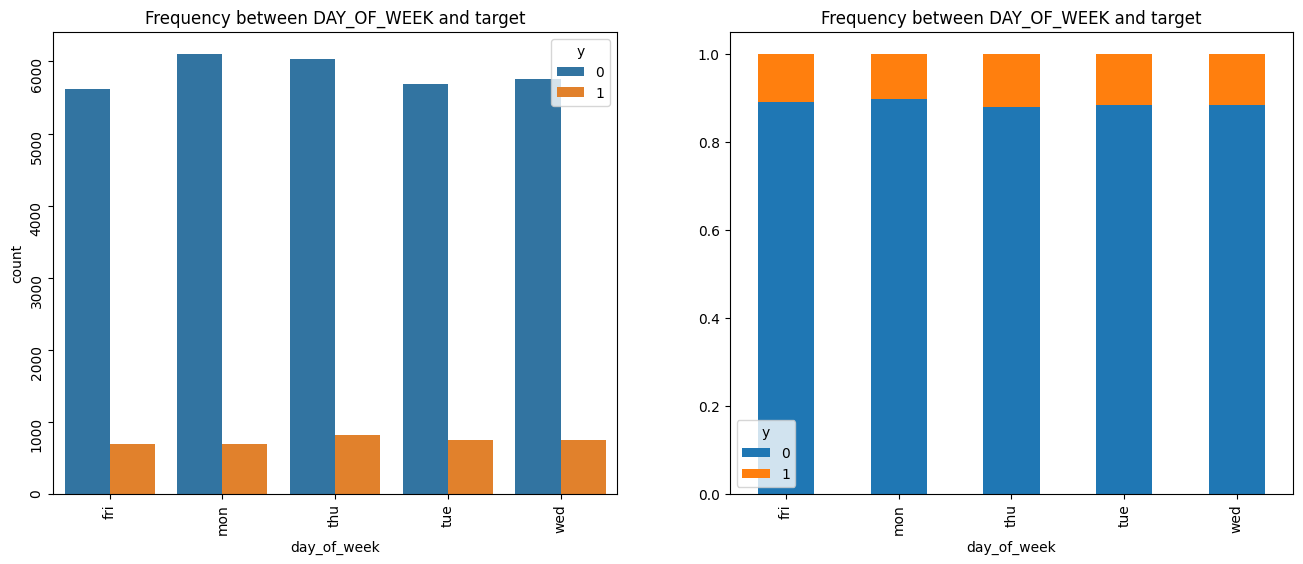

----------------------------------------------------------------------------------------------------


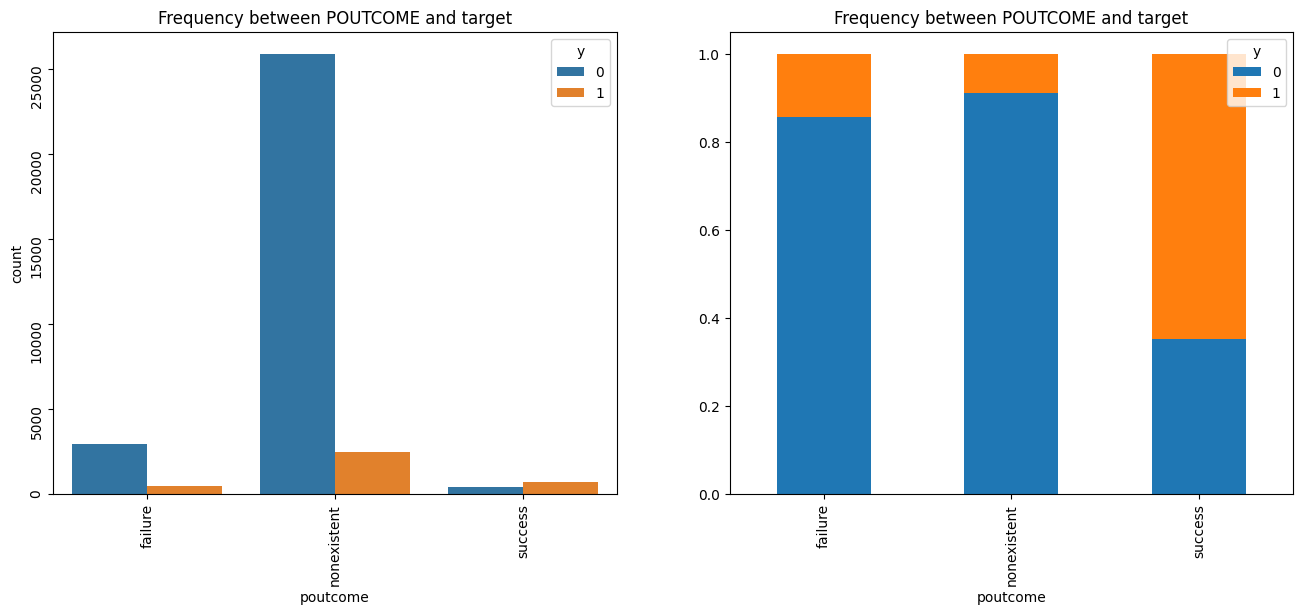

----------------------------------------------------------------------------------------------------


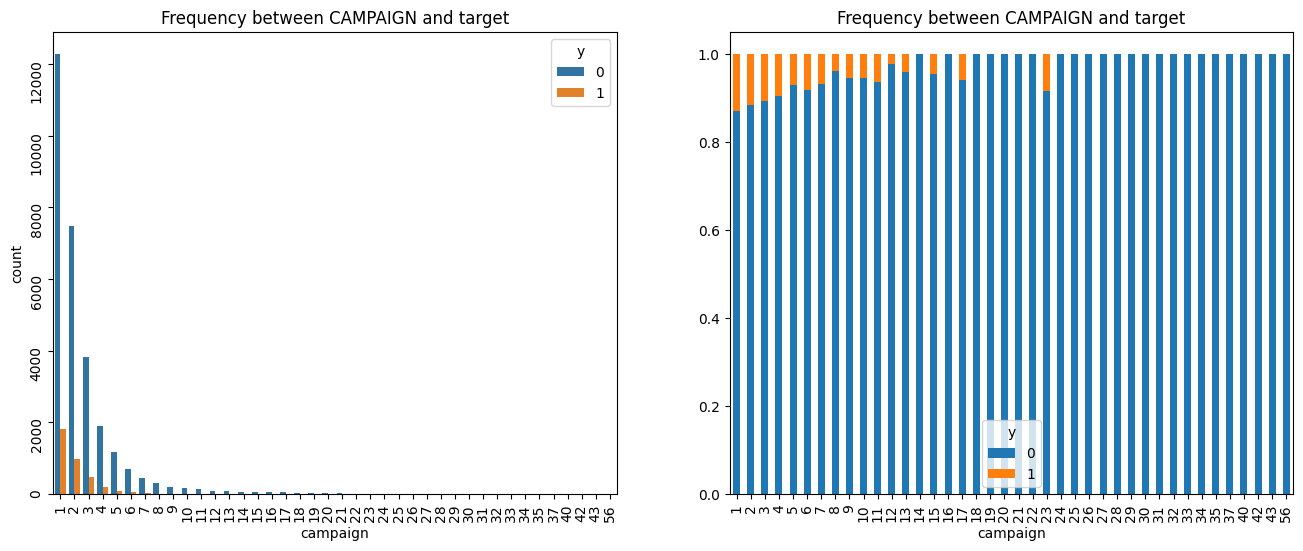

----------------------------------------------------------------------------------------------------


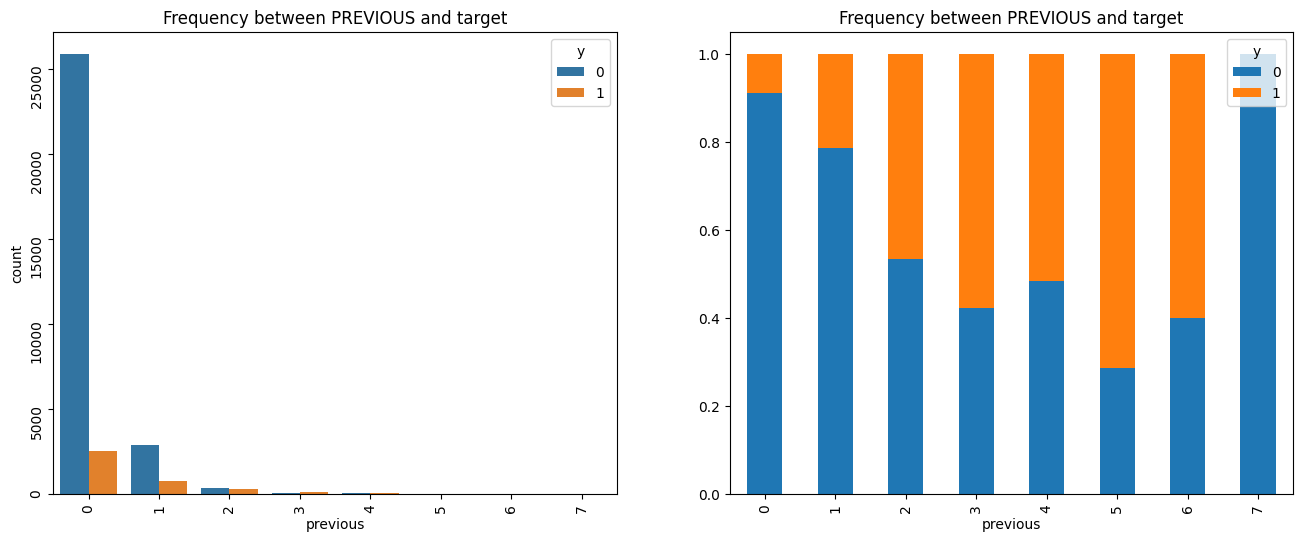

----------------------------------------------------------------------------------------------------


In [33]:
for cf in cat_feats:
    # display(df.groupby('job')['y'].agg(['count', 'median', 'mean', 'std']))
    df_freq = df.groupby([cf, "y"])[cf].count().reset_index(name="count")
    df_stack = df.groupby(cf)["y"].value_counts(normalize=True).unstack().fillna(0)

    figure, axis = plt.subplots(1, 2, figsize=(16, 6))

    sns.barplot(data=df_freq, x=cf, hue="y", y="count", ax=axis[0])
    axis[0].tick_params(rotation=90)
    axis[0].set_title(f"Frequency between {cf.upper()} and target")

    df_stack.plot(
        kind="bar", stacked=True, color=["tab:blue", "tab:orange"], ax=axis[1]
    )
    axis[1].set_title(f"Frequency between {cf.upper()} and target")
    plt.show()

    print("-" * 100)

### basic preprocess

In [34]:
# education --> basics
df["education"] = df["education"].apply(lambda x: "basic" if "basic" in x else x)

# campaign --> drop low counted
campaign_to_drop = (
    df["campaign"].value_counts()[df["campaign"].value_counts() < 20].index
)
df.loc[df["campaign"].isin(campaign_to_drop), "campaign"] = 22

In [35]:
campaign_to_drop

Index([19, 22, 24, 23, 27, 25, 26, 31, 29, 28, 30, 35, 33, 43, 32, 42, 34, 37,
       40, 56],
      dtype='int64', name='campaign')

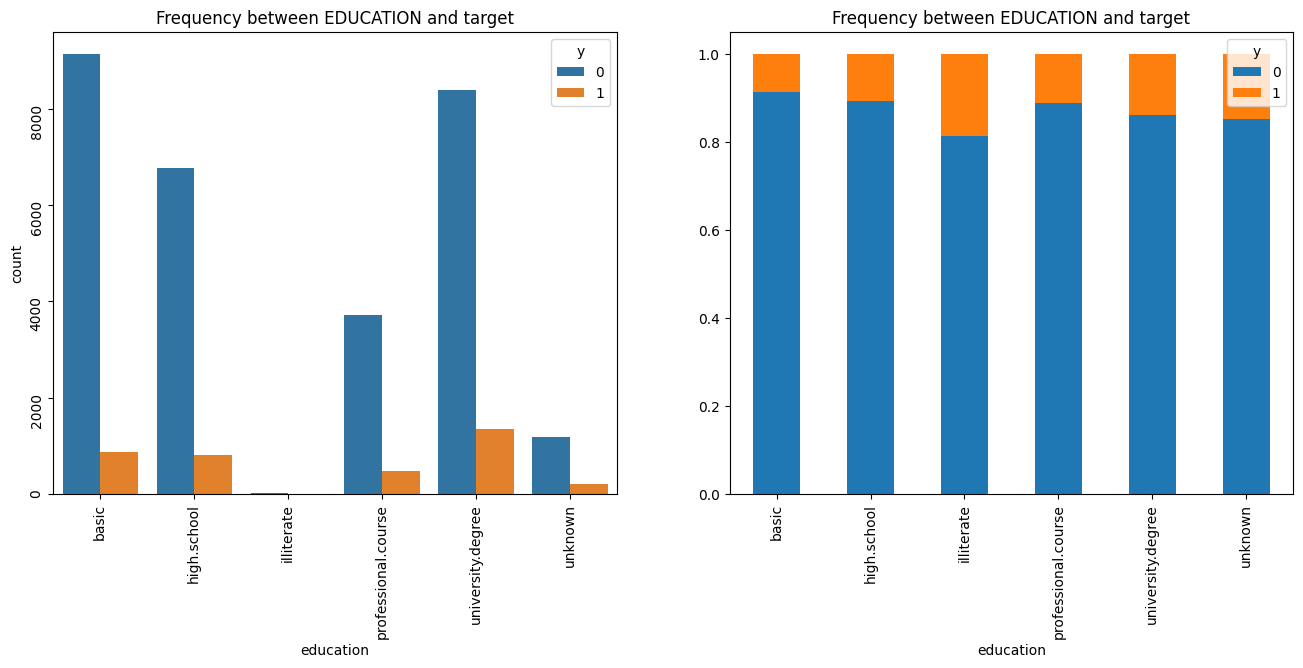

In [36]:
df_freq = df.groupby(["education", "y"])["education"].count().reset_index(name="count")
df_stack = df.groupby("education")["y"].value_counts(normalize=True).unstack().fillna(0)

figure, axis = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=df_freq, x="education", hue="y", y="count", ax=axis[0])
axis[0].tick_params(rotation=90)
axis[0].set_title(f"Frequency between {'education'.upper()} and target")

df_stack.plot(kind="bar", stacked=True, color=["tab:blue", "tab:orange"], ax=axis[1])
axis[1].set_title(f"Frequency between {'education'.upper()} and target")
plt.show()

In [37]:
X = df.drop(["y", "age_bins", "duration_bins"], axis=1).copy()
y = df["y"].copy()

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [39]:
X_train.shape, y_train.shape

((23037, 14), (23037,))

In [40]:
y_train.mean(), y_test.mean()

(0.11264487563484829, 0.11263040615820925)

### metics

In [41]:
from sklearn.metrics import (
    f1_score,
    fbeta_score,
    precision_score,
    recall_score,
    roc_auc_score,
)

In [42]:
# Try to maximize f2_score, because it seems than FN is more valuable then FP.
# We don't want to lose potential clients, we will get more calls (increase FP too).

In [43]:
def f2_score_custom(true, pred):
    pred_bin = (pred > 0.5).astype(int)
    return fbeta_score(true, pred_bin, beta=2)

In [44]:
def print_eval_metrics(true, pred, treshold=0.5):
    pred_bin = (pred > 0.5).astype(int)

    precision = precision_score(true, pred_bin)
    recall = recall_score(true, pred_bin)
    f1 = f1_score(true, pred_bin)
    f2 = f2_score_custom(true, pred)
    roc_auc = roc_auc_score(true, pred)

    print(f"precision {precision}")
    print(f"recall {recall}")
    print(f"f1 {f1}")
    print(f"f2 {f2}")
    print(f"roc_auc {roc_auc}")

In [45]:
def to_mean_eval_metrics(true, pred, treshold=0.5):
    pred_bin = (pred > 0.5).astype(int)

    precision = precision_score(true, pred_bin)
    recall = recall_score(true, pred_bin)
    f1 = f1_score(true, pred_bin)
    f2 = f2_score_custom(true, pred)
    roc_auc = roc_auc_score(true, pred)

    return [precision, recall, f1, f2, roc_auc]

### baseline

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [47]:
X = df.drop(["y", "age_bins", "duration_bins"], axis=1).copy()
y = df["y"].copy()

In [48]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
train_scores = []
test_scores = []
lr_models = []

for train_index, test_index in skf.split(X, y):
    # split
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # emplty
    X_train_base = pd.DataFrame()
    X_test_base = pd.DataFrame()

    # ohe for cat feats
    for col in cat_feats:
        # fit
        enc = OneHotEncoder(handle_unknown="ignore")
        enc.fit(X_train[col].values.reshape(-1, 1))

        # columns
        names = [f"{col}-{x}" for x in enc.categories_[0]]

        # ...
        X_train_enc = pd.DataFrame(
            enc.transform(X_train[col].values.reshape(-1, 1)).toarray().astype(int),
            columns=names,
        )
        X_test_enc = pd.DataFrame(
            enc.transform(X_test[col].values.reshape(-1, 1)).toarray().astype(int),
            columns=names,
        )

        # to pandas

        X_train_base = pd.concat([X_train_base, X_train_enc], axis=1)
        X_test_base = pd.concat([X_test_base, X_test_enc], axis=1)

    # scaler int feats
    sc = StandardScaler()
    sc.fit(X_train[[x for x in X if x not in cat_feats]])

    X_train_sc = pd.DataFrame(
        sc.transform(X_train[[x for x in X if x not in cat_feats]]),
        columns=[x for x in X if x not in cat_feats],
    )
    X_test_sc = pd.DataFrame(
        sc.transform(X_test[[x for x in X if x not in cat_feats]]),
        columns=[x for x in X if x not in cat_feats],
    )

    X_train_base = pd.concat([X_train_base, X_train_sc], axis=1)
    X_test_base = pd.concat([X_test_base, X_test_sc], axis=1)

    # check
    print(X_train.shape, X_test.shape, X_train_base.shape, X_test_base.shape)

    # fit model
    lr = LogisticRegression(random_state=42, class_weight="balanced")
    lr.fit(X_train_base, y_train)
    lr_models.append(lr)

    # preds
    train_scores.append(
        to_mean_eval_metrics(y_train, lr.predict_proba(X_train_base)[:, 1])
    )
    test_scores.append(
        to_mean_eval_metrics(y_test, lr.predict_proba(X_test_base)[:, 1])
    )

(21940, 14) (10970, 14) (21940, 82) (10970, 82)
(21940, 14) (10970, 14) (21940, 82) (10970, 82)
(21940, 14) (10970, 14) (21940, 81) (10970, 81)


In [49]:
np.array(train_scores).mean(axis=0), np.array(test_scores).mean(axis=0)

(array([0.4222489 , 0.82681413, 0.55900899, 0.6938497 , 0.91731304]),
 array([0.41979782, 0.81980312, 0.55525189, 0.68856794, 0.91415831]))

In [71]:
lr_fi = pd.concat(
    [pd.DataFrame(lr.coef_[0], lr.feature_names_in_)[:15] for lr in lr_models]
).sort_values(0, key=lambda x: abs(x), ascending=False)

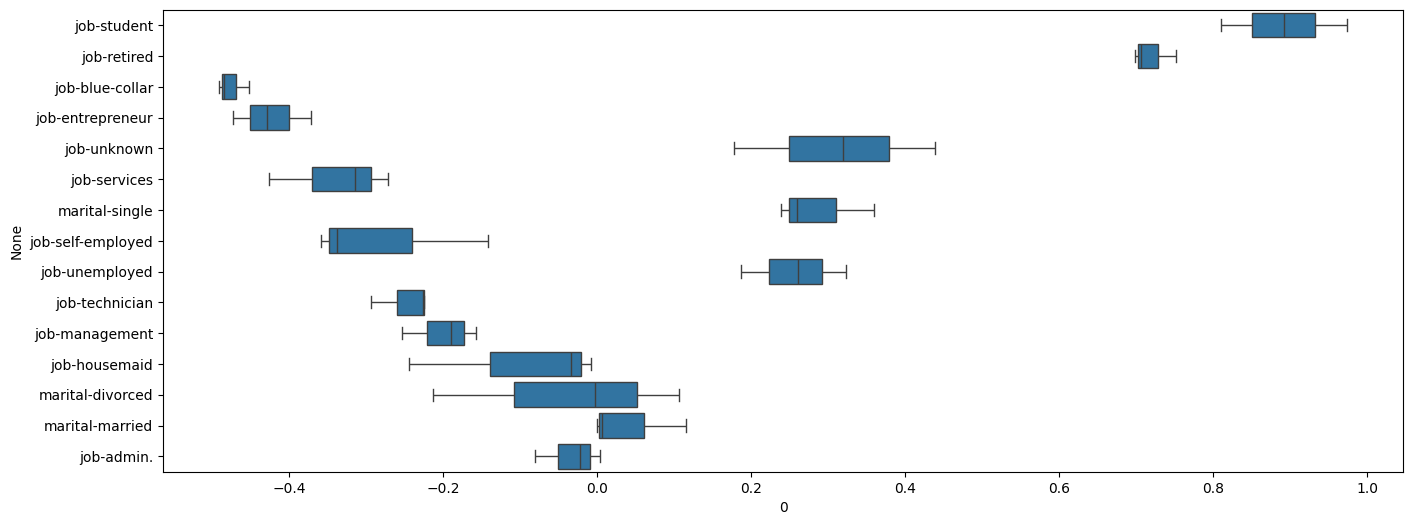

In [78]:
plt.figure(figsize=(16, 6))
sns.boxplot(
    data=lr_fi,
    x=0,
    y=lr_fi.index
)
plt.show()

#### drop useless features

In [50]:
from sklearn.feature_selection import RFE

In [83]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rfe_train_scores = []
rfe_test_scores = []
rfe_models = []

for train_index, test_index in skf.split(X, y):
    # split
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # emplty
    X_train_base = pd.DataFrame()
    X_test_base = pd.DataFrame()

    # ohe for cat feats
    for col in cat_feats:
        # fit
        enc = OneHotEncoder(handle_unknown="ignore")
        enc.fit(X_train[col].values.reshape(-1, 1))

        # columns
        names = [f"{col}-{x}" for x in enc.categories_[0]]

        # ...
        X_train_enc = pd.DataFrame(
            enc.transform(X_train[col].values.reshape(-1, 1)).toarray().astype(int),
            columns=names,
        )
        X_test_enc = pd.DataFrame(
            enc.transform(X_test[col].values.reshape(-1, 1)).toarray().astype(int),
            columns=names,
        )

        # to pandas

        X_train_base = pd.concat([X_train_base, X_train_enc], axis=1)
        X_test_base = pd.concat([X_test_base, X_test_enc], axis=1)

    # scaler int feats
    sc = StandardScaler()
    sc.fit(X_train[[x for x in X if x not in cat_feats]])

    X_train_sc = pd.DataFrame(
        sc.transform(X_train[[x for x in X if x not in cat_feats]]),
        columns=[x for x in X if x not in cat_feats],
    )
    X_test_sc = pd.DataFrame(
        sc.transform(X_test[[x for x in X if x not in cat_feats]]),
        columns=[x for x in X if x not in cat_feats],
    )

    X_train_base = pd.concat([X_train_base, X_train_sc], axis=1)
    X_test_base = pd.concat([X_test_base, X_test_sc], axis=1)

    # check
    print(X_train.shape, X_test.shape, X_train_base.shape, X_test_base.shape)

    # fit model
    lr_rfe = LogisticRegression(random_state=42, class_weight="balanced")
    rfe = RFE(lr_rfe, n_features_to_select=15)
    rfe.fit(X_train_base, y_train)
    rfe_models.append(rfe)

    # preds
    rfe_train_scores.append(
        to_mean_eval_metrics(y_train, rfe.predict_proba(X_train_base)[:, 1])
    )
    rfe_test_scores.append(
        to_mean_eval_metrics(y_test, rfe.predict_proba(X_test_base)[:, 1])
    )

(21940, 14) (10970, 14) (21940, 82) (10970, 82)
(21940, 14) (10970, 14) (21940, 82) (10970, 82)
(21940, 14) (10970, 14) (21940, 81) (10970, 81)


In [84]:
np.array(rfe_train_scores).mean(axis=0), np.array(rfe_test_scores).mean(axis=0)

(array([0.41448023, 0.80442278, 0.54706059, 0.67701175, 0.91057744]),
 array([0.41368214, 0.79741581, 0.54472228, 0.67258795, 0.90894682]))

In [98]:
lr_rfe_fi = pd.concat(
    [pd.DataFrame(lr_rfe.estimator_.coef_[0], lr_rfe.get_feature_names_out())[:15] for lr_rfe in rfe_models]
).sort_values(0, key=lambda x: abs(x), ascending=False)

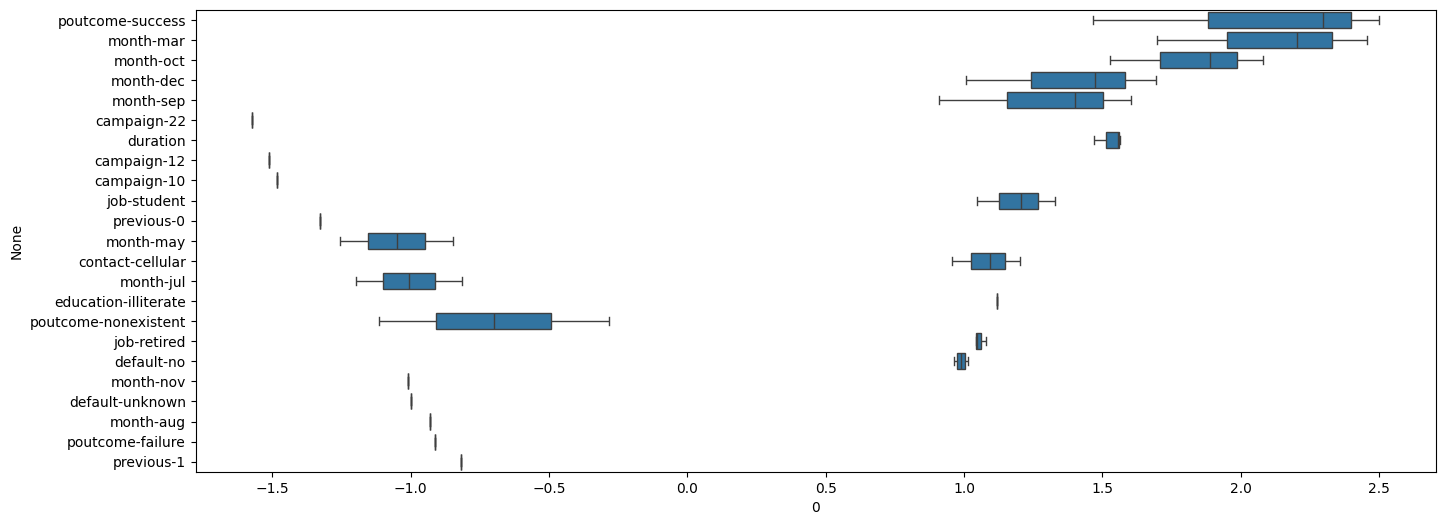

In [99]:
plt.figure(figsize=(16, 6))
sns.boxplot(
    data=lr_rfe_fi,
    x=0,
    y=lr_rfe_fi.index
)
plt.show()

### JS encoding

In [100]:
X = df.drop("y", axis=1).copy()

In [101]:
df[cat_feats + ["age_bins", "duration_bins"]].apply((set)).apply(len)

job              12
marital           4
education         6
default           3
housing           3
loan              3
contact           2
month            10
day_of_week       5
poutcome          3
campaign         21
previous          8
age_bins         20
duration_bins    20
dtype: int64

In [102]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
enc_train_scores = []
enc_test_scores = []
enc_models = []

for train_index, test_index in skf.split(X, y):
    # split
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # JS encoding
    jse = ce.JamesSteinEncoder(cols=cat_feats + ["age_bins", "duration_bins"])
    X_train_base = jse.fit_transform(X_train, y_train)
    X_test_base = jse.transform(X_test)

    # scaler int feats
    sc = StandardScaler()
    sc.fit(X_train[int_feats])

    X_train_base[int_feats] = sc.transform(X_train[int_feats])
    X_test_base[int_feats] = sc.transform(X_test[int_feats])

    # check
    print(X_train.shape, X_test.shape, X_train_base.shape, X_test_base.shape)

    # fit model
    lr_enc = LogisticRegression(random_state=42, class_weight="balanced")
    # rfe = RFE(lr_rfe, n_features_to_select=15)
    lr_enc.fit(X_train_base, y_train)
    enc_models.append(lr_enc)

    # preds
    enc_train_scores.append(
        to_mean_eval_metrics(y_train, lr_enc.predict_proba(X_train_base)[:, 1])
    )
    enc_test_scores.append(
        to_mean_eval_metrics(y_test, lr_enc.predict_proba(X_test_base)[:, 1])
    )

(21940, 16) (10970, 16) (21940, 16) (10970, 16)
(21940, 16) (10970, 16) (21940, 16) (10970, 16)
(21940, 16) (10970, 16) (21940, 16) (10970, 16)


In [103]:
np.array(enc_train_scores).mean(axis=0), np.array(enc_test_scores).mean(axis=0)

(array([0.42079545, 0.82128412, 0.55646822, 0.68994542, 0.91743606]),
 array([0.42024012, 0.81926243, 0.55552263, 0.68851036, 0.9161143 ]))

In [114]:
lr_enc_fi = pd.concat(
    [pd.DataFrame(enc.coef_[0], enc.feature_names_in_) for enc in enc_models]
).sort_values(0, ascending=False)

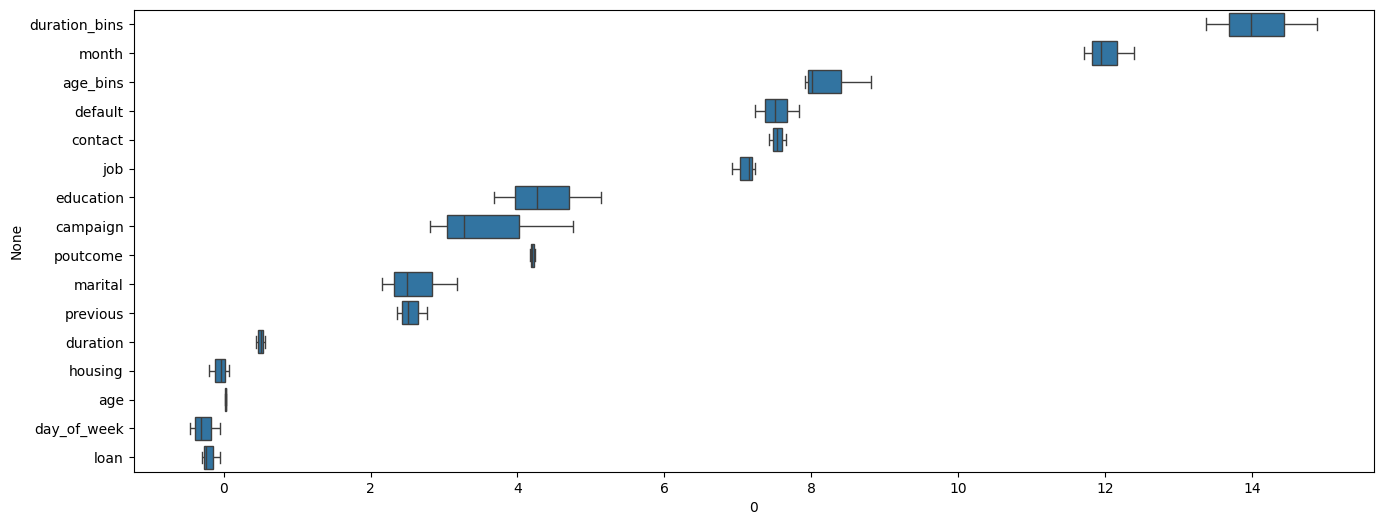

In [115]:
plt.figure(figsize=(16, 6))
sns.boxplot(
    data=lr_enc_fi,
    x=0,
    y=lr_enc_fi.index
)
plt.show()

### Catboost

In [19]:
import optuna
from catboost import CatBoostClassifier, Pool, cv

In [20]:
X = df.drop("y", axis=1)
y = df["y"]

In [21]:
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,age_bins,duration_bins
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,0,nonexistent,"(47.0, 49.0]","(221.0, 248.0]"
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,1,failure,"(35.0, 37.0]","(200.0, 221.0]"
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,0,nonexistent,"(58.0, 98.0]","(750.0, 4918.0]"
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,0,nonexistent,"(35.0, 37.0]","(117.0, 131.0]"
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,0,nonexistent,"(58.0, 98.0]","(319.0, 369.0]"


In [22]:
cv_dataset = Pool(
    data=X, label=y, cat_features=cat_feats + ["age_bins", "duration_bins"]
)

In [23]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500, step=100),
        "depth": trial.suggest_int("depth", 2, 6),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.1, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "early_stopping_rounds": trial.suggest_int(
            "early_stopping_rounds", 10, 80, step=10
        ),
        "max_ctr_complexity": trial.suggest_int("max_ctr_complexity", 0, 6),
        "loss_function": "Logloss",
        "eval_metric": "F:beta=2",
        "custom_metric": ["Precision", "Recall"],
        "auto_class_weights": "Balanced",
        "verbose": False,
    }

    cv_results = cv(
        cv_dataset,
        params,
        fold_count=3,
        stratified=True,
        partition_random_seed=42,
        verbose_eval=False,
        plot=True,
    )
    return cv_results["test-F:beta=2-mean"].iloc[-1]  # last value from iterations

In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-02-15 15:45:49,324] A new study created in memory with name: no-name-d5cfc7b8-89ad-4ef9-ab00-4def056e4b9c


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8364625884
bestIteration = 3

Training on fold [1/3]

bestTest = 0.8274946306
bestIteration = 4

Training on fold [2/3]


[I 2025-02-15 15:45:55,128] Trial 0 finished with value: 0.8402103300627602 and parameters: {'iterations': 500, 'depth': 5, 'learning_rate': 0.044509104697706636, 'l2_leaf_reg': 4.368445507590881, 'random_strength': 1.3365306652167352, 'bagging_temperature': 0.7230076061793834, 'early_stopping_rounds': 20, 'max_ctr_complexity': 5}. Best is trial 0 with value: 0.8402103300627602.



bestTest = 0.8767064754
bestIteration = 96



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8676126701
bestIteration = 193

Training on fold [1/3]

bestTest = 0.8549052796
bestIteration = 192

Training on fold [2/3]


[I 2025-02-15 15:46:19,291] Trial 1 finished with value: 0.8661151060595152 and parameters: {'iterations': 200, 'depth': 4, 'learning_rate': 0.024810964336326086, 'l2_leaf_reg': 0.03298428350746252, 'random_strength': 0.4040101838932973, 'bagging_temperature': 0.2875002892004521, 'early_stopping_rounds': 80, 'max_ctr_complexity': 3}. Best is trial 1 with value: 0.8661151060595152.



bestTest = 0.8802302585
bestIteration = 182



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8766078674
bestIteration = 170

Training on fold [1/3]

bestTest = 0.8623384667
bestIteration = 195

Training on fold [2/3]


[I 2025-02-15 15:46:35,622] Trial 2 finished with value: 0.8699571858010576 and parameters: {'iterations': 200, 'depth': 3, 'learning_rate': 0.223885849148835, 'l2_leaf_reg': 0.09275897630636419, 'random_strength': 0.15976530864038813, 'bagging_temperature': 0.9229337287734781, 'early_stopping_rounds': 60, 'max_ctr_complexity': 3}. Best is trial 2 with value: 0.8699571858010576.



bestTest = 0.8802684054
bestIteration = 95



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8357189323
bestIteration = 0

Training on fold [1/3]

bestTest = 0.806083953
bestIteration = 0

Training on fold [2/3]


[I 2025-02-15 15:46:36,306] Trial 3 finished with value: 0.7876987391730678 and parameters: {'iterations': 300, 'depth': 2, 'learning_rate': 0.05067025241307037, 'l2_leaf_reg': 0.8530356030072312, 'random_strength': 0.2598058163582457, 'bagging_temperature': 0.98666541038429, 'early_stopping_rounds': 10, 'max_ctr_complexity': 1}. Best is trial 2 with value: 0.8699571858010576.



bestTest = 0.8109128413
bestIteration = 8



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8626810183
bestIteration = 298

Training on fold [1/3]

bestTest = 0.8523696862
bestIteration = 299

Training on fold [2/3]


[I 2025-02-15 15:46:58,149] Trial 4 finished with value: 0.8642056285836645 and parameters: {'iterations': 300, 'depth': 3, 'learning_rate': 0.07916223500729759, 'l2_leaf_reg': 0.0635400017779657, 'random_strength': 6.5135263363347935, 'bagging_temperature': 0.11585206347093457, 'early_stopping_rounds': 70, 'max_ctr_complexity': 5}. Best is trial 2 with value: 0.8699571858010576.



bestTest = 0.8800530895
bestIteration = 269



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8330790382
bestIteration = 3

Training on fold [1/3]

bestTest = 0.8132114629
bestIteration = 1

Training on fold [2/3]


[I 2025-02-15 15:47:01,611] Trial 5 finished with value: 0.8204309597431406 and parameters: {'iterations': 100, 'depth': 3, 'learning_rate': 0.055970169776620025, 'l2_leaf_reg': 6.3616809622795, 'random_strength': 3.922552303295647, 'bagging_temperature': 0.65319812715194, 'early_stopping_rounds': 20, 'max_ctr_complexity': 4}. Best is trial 2 with value: 0.8699571858010576.



bestTest = 0.8647082515
bestIteration = 83



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8463235814
bestIteration = 80

Training on fold [1/3]

bestTest = 0.8292327791
bestIteration = 91

Training on fold [2/3]


[I 2025-02-15 15:47:09,328] Trial 6 finished with value: 0.8429720730222936 and parameters: {'iterations': 100, 'depth': 3, 'learning_rate': 0.01767460938058962, 'l2_leaf_reg': 0.006133197372116637, 'random_strength': 0.2709464737416543, 'bagging_temperature': 0.3905738672889659, 'early_stopping_rounds': 60, 'max_ctr_complexity': 6}. Best is trial 2 with value: 0.8699571858010576.



bestTest = 0.8582441658
bestIteration = 97



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8683301988
bestIteration = 0

Training on fold [1/3]

bestTest = 0.8124855782
bestIteration = 4

Training on fold [2/3]


[I 2025-02-15 15:47:14,306] Trial 7 finished with value: 0.7985268311246526 and parameters: {'iterations': 200, 'depth': 5, 'learning_rate': 0.010570772013559436, 'l2_leaf_reg': 0.021372853920547323, 'random_strength': 8.492997526911847, 'bagging_temperature': 0.44329150999126166, 'early_stopping_rounds': 60, 'max_ctr_complexity': 2}. Best is trial 2 with value: 0.8699571858010576.



bestTest = 0.842571847
bestIteration = 0



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8576016189
bestIteration = 192

Training on fold [1/3]

bestTest = 0.8321014035
bestIteration = 0

Training on fold [2/3]


[I 2025-02-15 15:47:22,897] Trial 8 finished with value: 0.8515160248060486 and parameters: {'iterations': 200, 'depth': 2, 'learning_rate': 0.06596249222882193, 'l2_leaf_reg': 0.45160840747398656, 'random_strength': 0.7666295627602869, 'bagging_temperature': 0.1945821088751083, 'early_stopping_rounds': 50, 'max_ctr_complexity': 6}. Best is trial 2 with value: 0.8699571858010576.



bestTest = 0.8711135274
bestIteration = 161



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8279698019
bestIteration = 39

Training on fold [1/3]

bestTest = 0.8272683723
bestIteration = 10

Training on fold [2/3]


[I 2025-02-15 15:47:30,131] Trial 9 finished with value: 0.8270291758752393 and parameters: {'iterations': 500, 'depth': 3, 'learning_rate': 0.010660641971904654, 'l2_leaf_reg': 2.2775435098222814, 'random_strength': 1.0132144989419138, 'bagging_temperature': 0.26445334234394213, 'early_stopping_rounds': 80, 'max_ctr_complexity': 4}. Best is trial 2 with value: 0.8699571858010576.



bestTest = 0.85035981
bestIteration = 33



In [28]:
best_params = study.best_trial.params
best_params["loss_function"] = "Logloss"
best_params["eval_metric"] = "F:beta=2"
best_params["custom_metric"] = ["Precision", "Recall"]
best_params["auto_class_weights"] = "Balanced"
best_params["cat_features"] = cat_feats + ["age_bins", "duration_bins"]
best_params["verbose"] = False
best_params

{'iterations': 200,
 'depth': 3,
 'learning_rate': 0.223885849148835,
 'l2_leaf_reg': 0.09275897630636419,
 'random_strength': 0.15976530864038813,
 'bagging_temperature': 0.9229337287734781,
 'early_stopping_rounds': 60,
 'max_ctr_complexity': 3,
 'loss_function': 'Logloss',
 'eval_metric': 'F:beta=2',
 'custom_metric': ['Precision', 'Recall'],
 'auto_class_weights': 'Balanced',
 'cat_features': ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome',
  'campaign',
  'previous',
  'age_bins',
  'duration_bins'],
 'verbose': False}

In [29]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cat_train_scores = []
cat_test_scores = []
cat_models = []

for train_index, test_index in skf.split(X, y):
    # split
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # fit
    cb_model = CatBoostClassifier(**best_params)
    cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)
    cat_models.append(cb_model)

    # preds
    cat_train_scores.append(
        to_mean_eval_metrics(y_train, cb_model.predict_proba(X_train)[:, 1])
    )
    cat_test_scores.append(
        to_mean_eval_metrics(y_test, cb_model.predict_proba(X_test)[:, 1])
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

NameError: name 'to_mean_eval_metrics' is not defined

In [116]:
np.array(cat_train_scores).mean(axis=0), np.array(cat_test_scores).mean(axis=0)

(array([0.42522833, 0.88386928, 0.57417722, 0.72699821, 0.93171935]),
 array([0.42023069, 0.87618084, 0.56799776, 0.71991392, 0.92679273]))

In [117]:
fi = pd.concat(
    [pd.DataFrame(cbm.feature_importances_, cbm.feature_names_) for cbm in cat_models]
).sort_values(0, ascending=False)

<Axes: xlabel='0', ylabel='None'>

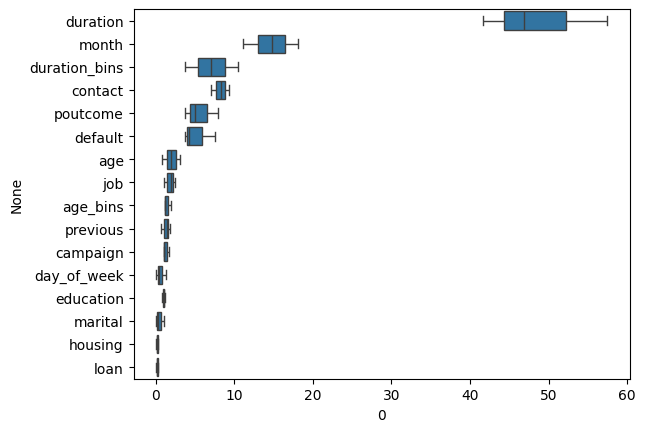

In [118]:
sns.boxplot(
    data=fi,
    x=0,
    y=fi.index,
    orient="h",
)

### Create some new feats

In [125]:
import copy

In [120]:
cat_feats

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'campaign',
 'previous']

In [119]:
from gensim.models import Word2Vec

In [246]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

In [143]:
sentences = df[cat_feats].values.tolist()
df[cat_feats].values.shape

(32910, 12)

In [188]:
w2v_model = Word2Vec(sentences, vector_size=1, window=5, min_count=1, workers=4)

In [189]:
def get_category_vector(vector):
    return vector.apply(lambda x: w2v_model.wv[x] if x in w2v_model.wv else None)

In [194]:
df_vec = pd.DataFrame()

for col in cat_feats:

    tmp = get_category_vector(df[col]).apply(pd.Series)
    tmp.columns = tmp.columns.astype(str) + "_vec_" + col

    df_vec = pd.concat([df_vec, tmp], axis=1)

In [234]:
pca = PCA(n_components=6)
df_vec_pca = pca.fit_transform(df_vec)
print(pca.explained_variance_ratio_.sum())

0.961999


In [ ]:
clustering = DBSCAN(eps=3, min_samples=2, n_jobs=-1).fit(df_vec_pca)

In [ ]:
clustering.labels_

<Axes: >

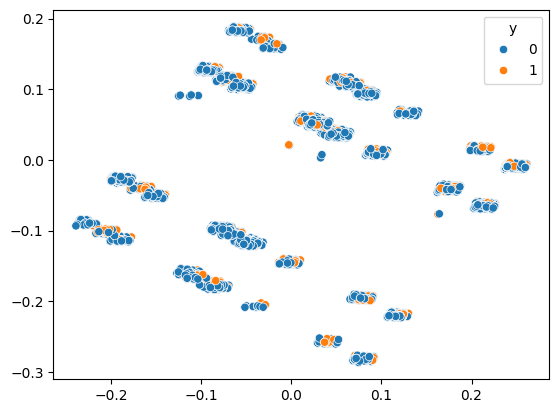

In [238]:
sns.scatterplot(x=df_vec_pca[:, 0], y=df_vec_pca[:, 1], hue=df['y'])

<Axes: >

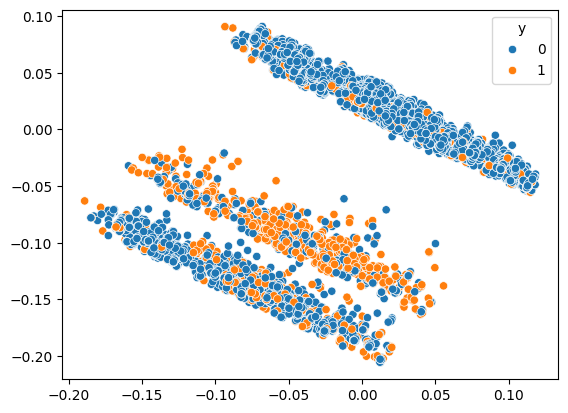

In [239]:
sns.scatterplot(x=df_vec_pca[:, 2], y=df_vec_pca[:, 3], hue=df['y'])

In [244]:
df_vec_pca_tsne = TSNE(
    max_iter=300,
    n_components=2,
    learning_rate=100,
    init='random',
    perplexity=50,
    n_jobs=-1
).fit_transform(df_vec_pca)

/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


<Axes: >

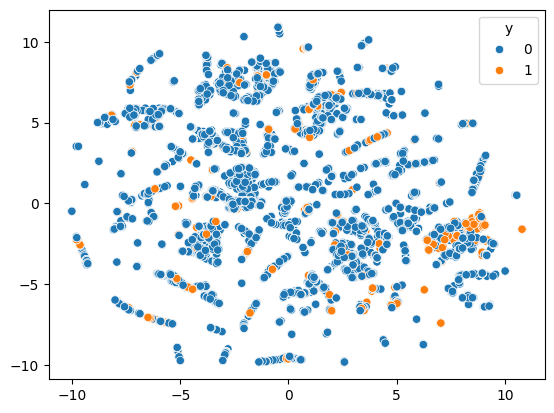

In [245]:
sns.scatterplot(x=df_vec_pca_tsne[:, 0], y=df_vec_pca_tsne[:, 1], hue=df['y'])

<Axes: >

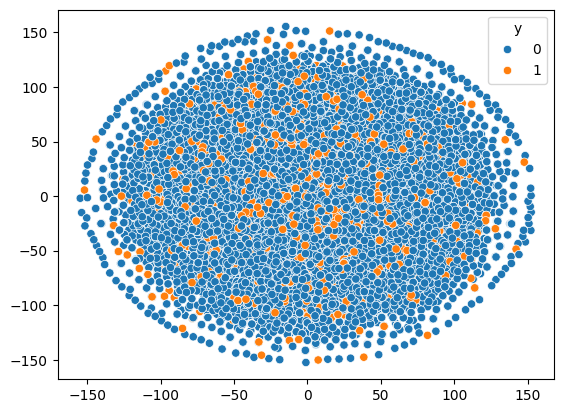

In [240]:
sns.scatterplot(x=df_vec_pca_tsne[:, 0], y=df_vec_pca_tsne[:, 1], hue=df['y'])